In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import random
import seaborn as sns
import pandas as pd
import pickle
import math
import torchaudio

from torchaudio.transforms import TimeMasking, FrequencyMasking
from torchvision.ops import SqueezeExcitation
from torchinfo import summary
from torchsummary import summary
from torchvision.ops import SqueezeExcitation
from tqdm import tqdm
from torchvision import datasets, transforms
from collections import defaultdict
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
from functools import reduce
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

pd.set_option('future.no_silent_downcasting', True)

### Loading data

In [2]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.n_samples = 0
        self.dataset = []
        self.labels = set()  # To track unique labels
        self.load_audio_files(self.data_dir)

    def load_audio_files(self, path: str):
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                file_path = os.path.join(dirname, filename)
                label = dirname.split('\\')[-1]
       
                # my implementation start
                if '0' <= label <= '9':
                    label_index = ord(label) - ord('0')
                elif 'a' <= label <= 'z':
                    label_index = ord(label) - ord('a') + 10
                else:
                    raise ValueError(f"Unexpected label: {label}")
                    break
                label_tensor = torch.tensor(label_index)
                # my implementation done
                
                # Add the label to the set of unique labels
                self.labels.add(label_tensor.item())
                
                # Load audio
                waveform, sample_rate = torchaudio.load(file_path)
                if self.transform is not None:
                    waveform_transformed = self.transform(waveform)
                
                if waveform_transformed.shape[2] != 64:
                    print("Wrong shape:", waveform_transformed.shape)
                    continue
                
                self.n_samples += 1
                self.dataset.append((waveform, label_tensor))

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        waveform, label = self.dataset[idx]
        return waveform, label

    def num_classes(self):
        return len(self.labels)  # Return the number of unique labels

In [3]:
sample_rate = 44100
to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=64, hop_length=300, n_fft=2048, win_length=1024)
mel_spectrogram_to_numpy = lambda spectrogram: spectrogram.log2()[0,:,:].numpy()
transforms = Compose([to_mel_spectrogram, mel_spectrogram_to_numpy, ToTensor()])
dataset = AudioDataset('..\\new_dataset_phone', transforms)
print("number of classes:", dataset.num_classes())

number of classes: 36


In [4]:
# Split the dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

init_train_set, init_val_set, init_test_set = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

print("Sample rate:", sample_rate)
print(train_size, val_size, test_size)

Sample rate: 44100
630 180 90


### Data augmentation setup

In [5]:
class TrainingDataset(Dataset):
    def __init__(self, base_dataset, transformations):
        super(TrainingDataset, self).__init__()
        self.base = base_dataset
        self.transformations = transformations

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        waveform, label = self.base[idx]
        return self.transformations(waveform), label

In [6]:
class TimeShifting():
    def __call__(self, samples):
        samples = samples.numpy()        
        shift = int(samples.shape[1] * 0.3)
        random_shift = random.randint(0, shift)
        data_roll = np.zeros_like(samples)
        data_roll[0] = np.roll(samples[0], random_shift)
        data_roll[1] = np.roll(samples[1], random_shift)
        return torch.tensor(data_roll)

In [7]:
aug_transforms = Compose([
    TimeShifting(),
    to_mel_spectrogram, mel_spectrogram_to_numpy, ToTensor(),
    FrequencyMasking(7),
    TimeMasking(7),
    FrequencyMasking(7),
    TimeMasking(7)
])

train_set = TrainingDataset(init_train_set, aug_transforms)
train_set_no_aug = TrainingDataset(init_train_set, transforms)
val_set = TrainingDataset(init_val_set, transforms)
test_set = TrainingDataset(init_test_set, transforms)

### Training set image (augmented vs non-augmented)

torch.Size([64, 64])


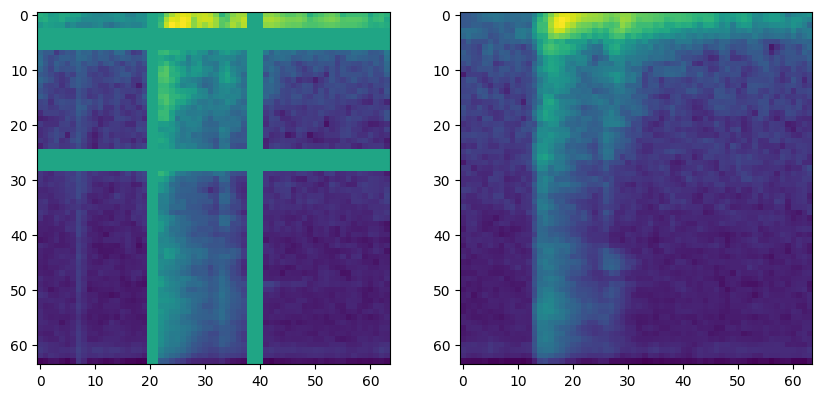

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(train_set[0][0][0], cmap='viridis')
ax2.imshow(val_set[0][0][0], cmap='viridis')
print(train_set[0][0][0].shape)
ax1.grid(False)
ax2.grid(False)
plt.show()

In [9]:
print("number of classes:", dataset.num_classes())

number of classes: 36


### CoAtNet (Model)

In [10]:
class Stem(nn.Sequential):
    def __init__(self, out_channels):
        super().__init__(
            nn.Conv2d(1, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3)
        )

In [11]:
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__()
        self.mb_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            nn.Conv2d(in_channels * expansion_factor, in_channels * expansion_factor, kernel_size=3, padding=1, groups=in_channels * expansion_factor),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            SqueezeExcitation(in_channels * expansion_factor, in_channels, activation=nn.GELU),
            nn.Conv2d(in_channels * expansion_factor, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        return x + self.mb_conv(x)

In [12]:
class DownsamplingMBConv(MBConv):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__(in_channels, out_channels, expansion_factor=4)
        self.mb_conv[1] = nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1, stride = 2)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.mb_conv(x)

In [13]:
class RelativeAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__()
        heads = out_channels // head_size
        self.heads = heads
        self.head_size = head_size
        self.image_size = image_size
        self.head_dim = heads * head_size
        self.attend = nn.Softmax(dim=-2) # Taken from My_CoAtNet
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.to_q = nn.Linear(in_channels, self.head_dim)
        self.to_k = nn.Linear(in_channels, self.head_dim)
        self.to_v = nn.Linear(in_channels, self.head_dim)
        self.to_output = nn.Sequential(
            nn.Linear(self.head_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(in_channels)
        
        self.relative_bias = nn.Parameter(torch.randn(heads, (2 * image_size - 1) * (2 * image_size - 1)))
        self.register_buffer("relative_indices", self.get_indices(image_size, image_size)) # Taken from My_CoAtNet
        self.precomputed_relative_bias = None
    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def get_relative_biases(self):
        # Relative bias caching mentioned in CoAtNet: Marrying Convolution and Attention for All Data Sizes
        if not self.training:
            return self.precomputed_relative_bias
        # Taken from od My_CoAtNet
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.relative_bias.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (self.image_size * self.image_size, self.image_size * self.image_size))
        return rel_pos_enc
    
    def reshape_for_linear(self, x):
        b, _, _, _ = x.shape
        return x.reshape(b, self.image_size * self.image_size, self.in_channels)
    
    def attention_score(self, x):
        b, _, h, _ = x.shape
        q = self.to_q(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        k = self.to_k(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        dots = torch.matmul(k.transpose(-1, -2), q) / math.sqrt(self.head_dim)
        relative_biases_indexed = self.get_relative_biases()
        return self.attend(dots + relative_biases_indexed)
    
    def relative_attention(self, x):
        b, _, _, _ = x.shape
        v = self.to_v(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        out = torch.matmul(v, self.attention_score(x)) # I figured this out after debugging (Still the same as My_CoAtNet)
        out = out.view(b, self.image_size, self.image_size, -1)
        return self.to_output(out).view(b, self.out_channels, self.image_size, self.image_size)
        
    def forward(self, x):
        return x + self.relative_attention(self.norm(x))
    
    def train(self, training):
        if not training:
            self.precomputed_relative_bias = self.get_relative_biases()
        super().train(training)
        
    # Taken from My_CoAtNet
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x)
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices
        

In [14]:
class DownsamplingRelativeAttention2d(RelativeAttention2d):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__(in_channels, out_channels, image_size, heads=8, head_size=32)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.normalization = nn.LayerNorm(in_channels)


    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
        
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.relative_attention(self.pool(self.norm(x)))

In [15]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, out_channels, expansion_factor=4):
        super().__init__()
        hidden_dim = out_channels * expansion_factor
        self.ffn = nn.Sequential(
            nn.Linear(out_channels, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(out_channels)
        self.out_channels = out_channels

    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def forward(self, x):
        old_shape = x.shape
        batch_size = old_shape[0]
        return x + torch.reshape(self.ffn(torch.reshape(self.norm(x), (batch_size, -1, self.out_channels))), old_shape)
    

In [16]:
class DownsampleTransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = DownsamplingRelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [17]:
class TransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = RelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [18]:
class Head(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)
        self.in_channels = in_channels
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool(x)
        x = torch.reshape(x, (batch_size, -1, self.in_channels))
        return torch.squeeze(self.fc(x))
    

In [19]:
class MyCoAtNet(nn.Sequential):
    def __init__(self, nums_blocks, layer_out_channels, num_classes=36):
        s0 = nn.Sequential(Stem(layer_out_channels[0]))
        
        s1 = [DownsamplingMBConv(layer_out_channels[0], layer_out_channels[1])]
        for i in range(nums_blocks[1] - 1):
            s1.append(MBConv(layer_out_channels[1], layer_out_channels[1]))
        s1 = nn.Sequential(*s1)
        
        s2 = [DownsamplingMBConv(layer_out_channels[1], layer_out_channels[2])]
        for i in range(nums_blocks[2] - 1):
            s2.append(MBConv(layer_out_channels[2], layer_out_channels[2]))
        s2 = nn.Sequential(*s2)
        
        s3 = [DownsampleTransformerBlock(layer_out_channels[2], layer_out_channels[3], 64 // 16)]
        for i in range(nums_blocks[3] - 1):
            s3.append(TransformerBlock(layer_out_channels[3], layer_out_channels[3], 64 // 16))
        s3 = nn.Sequential(*s3)
        
        s4 = [DownsampleTransformerBlock(layer_out_channels[3], layer_out_channels[4], 64 // 32)]
        for i in range(nums_blocks[4] - 1):
            s4.append(TransformerBlock(layer_out_channels[4], layer_out_channels[4], 64 // 32))
        s4 = nn.Sequential(*s4)
        
        head = Head(layer_out_channels[4], num_classes)
        
        super().__init__(
            s0,
            s1,
            s2,
            s3,
            s4,
            head
        )
            

In [20]:
# CoAtNet-1
nums_blocks = [2, 2, 3, 5, 2]           # L
channels = [64, 96, 192, 384, 768]      # D

model = MyCoAtNet(nums_blocks, channels)

c:\Users\user\miniconda3\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [21]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.apply(init_linear)
model.to(device)

print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

summary(model, input_size=(1, 64, 64))

Number of parameters: 24,033,296
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              GELU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 30, 30]          36,928
         MaxPool2d-5           [-1, 64, 15, 15]               0
            Conv2d-6           [-1, 96, 15, 15]           6,144
       BatchNorm2d-7           [-1, 64, 30, 30]             128
            Conv2d-8          [-1, 256, 15, 15]          16,640
       BatchNorm2d-9          [-1, 256, 15, 15]             512
             GELU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]           2,560
      BatchNorm2d-12          [-1, 256, 15, 15]             512
             GELU-13          [-1, 256, 15, 15]               0
Adapti

### Training

In [23]:
train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_set,
    batch_size=16,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=16,
    shuffle=True
)

In [24]:
# Adapted from My_CoAtNet
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.LayerNorm, nn.BatchNorm2d)
    
    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [25]:
cost = torch.nn.CrossEntropyLoss()

learning_rate = 5e-4
weight_decay = 0.1
num_epochs = 1100
min_learning_rate = 1e-6

param_dict = {pn: p for pn, p in model.named_parameters()}
parameters_decay, parameters_no_decay = separate_parameters(model)
parameter_groups = [
    {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
    {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
]
optimizer = torch.optim.Adam(parameter_groups, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=min_learning_rate / learning_rate, total_iters=num_epochs)

In [26]:
# Adapted from My_CoAtNet
def plot_results(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.title("Loss")
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(["Training loss", "Validation loss"], loc =  "best")
    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(train_accuracies)
    plt.plot(val_accuracies)
    plt.legend(["Training accuracy", "Validation accuracy"], loc =  "best")
    plt.show()

In [27]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

Epoch [1/1100], Loss: 19.457693099975586, Accuracy: 0.02857142857142857 Correct: 18 Total: 630 LR: 0.0005 -> 0.0004995463636363637
Validation Accuracy: 0.022222222222222223 Validation loss: 12.37197494506836 Correct: 4 Total: 180
Epoch [2/1100], Loss: 9.236127853393555, Accuracy: 0.0380952380952381 Correct: 24 Total: 630 LR: 0.0004995463636363637 -> 0.0004990927272727273
Validation Accuracy: 0.03333333333333333 Validation loss: 9.438429832458496 Correct: 6 Total: 180
Epoch [3/1100], Loss: 7.150831699371338, Accuracy: 0.03968253968253968 Correct: 25 Total: 630 LR: 0.0004990927272727273 -> 0.000498639090909091
Validation Accuracy: 0.016666666666666666 Validation loss: 8.6747407913208 Correct: 3 Total: 180
Epoch [4/1100], Loss: 5.3496413230896, Accuracy: 0.03968253968253968 Correct: 25 Total: 630 LR: 0.000498639090909091 -> 0.0004981854545454546
Validation Accuracy: 0.022222222222222223 Validation loss: 4.211577892303467 Correct: 4 Total: 180
Epoch [5/1100], Loss: 6.994863033294678, Accur

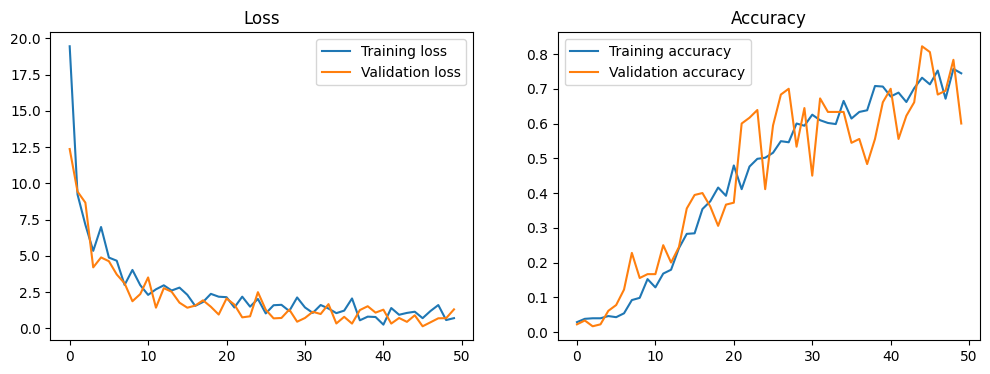

Epoch [51/1100], Loss: 0.9913444519042969, Accuracy: 0.7603174603174603 Correct: 479 Total: 630 LR: 0.0004773181818181822 -> 0.0004768645454545458
Validation Accuracy: 0.7777777777777778 Validation loss: 0.03470494598150253 Correct: 140 Total: 180
Epoch [52/1100], Loss: 1.1326037645339966, Accuracy: 0.7333333333333333 Correct: 462 Total: 630 LR: 0.0004768645454545458 -> 0.0004764109090909094
Validation Accuracy: 0.75 Validation loss: 0.32682129740715027 Correct: 135 Total: 180
Epoch [53/1100], Loss: 1.1245354413986206, Accuracy: 0.7126984126984127 Correct: 449 Total: 630 LR: 0.0004764109090909094 -> 0.00047595727272727305
Validation Accuracy: 0.7555555555555555 Validation loss: 0.6231882572174072 Correct: 136 Total: 180
Epoch [54/1100], Loss: 1.4363937377929688, Accuracy: 0.7206349206349206 Correct: 454 Total: 630 LR: 0.00047595727272727305 -> 0.0004755036363636367
Validation Accuracy: 0.6222222222222222 Validation loss: 0.7646760940551758 Correct: 112 Total: 180
Epoch [55/1100], Loss:

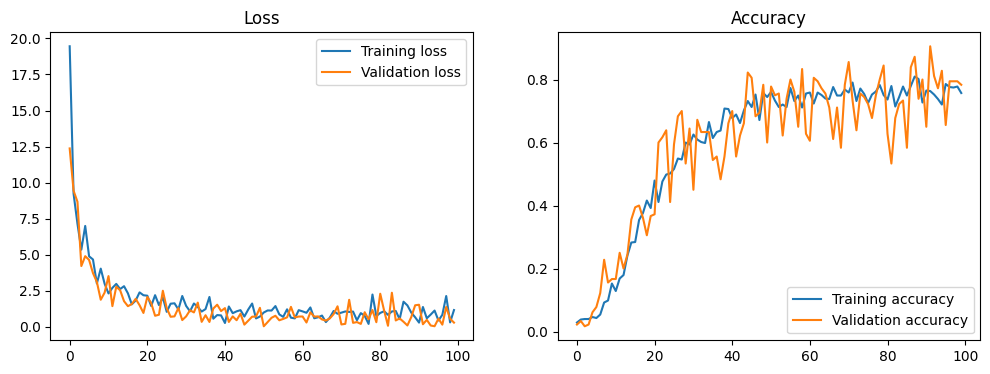

Epoch [101/1100], Loss: 0.4126221239566803, Accuracy: 0.7793650793650794 Correct: 491 Total: 630 LR: 0.0004546363636363642 -> 0.00045418272727272785
Validation Accuracy: 0.7555555555555555 Validation loss: 0.6574735641479492 Correct: 136 Total: 180
Epoch [102/1100], Loss: 0.789849579334259, Accuracy: 0.7396825396825397 Correct: 466 Total: 630 LR: 0.00045418272727272785 -> 0.0004537290909090915
Validation Accuracy: 0.8055555555555556 Validation loss: 0.40886998176574707 Correct: 145 Total: 180
Epoch [103/1100], Loss: 0.37787386775016785, Accuracy: 0.7952380952380952 Correct: 501 Total: 630 LR: 0.0004537290909090915 -> 0.0004532754545454551
Validation Accuracy: 0.7666666666666667 Validation loss: 1.55695641040802 Correct: 138 Total: 180
Epoch [104/1100], Loss: 0.9605578780174255, Accuracy: 0.7396825396825397 Correct: 466 Total: 630 LR: 0.0004532754545454551 -> 0.00045282181818181874
Validation Accuracy: 0.4888888888888889 Validation loss: 1.5157582759857178 Correct: 88 Total: 180
Epoch [

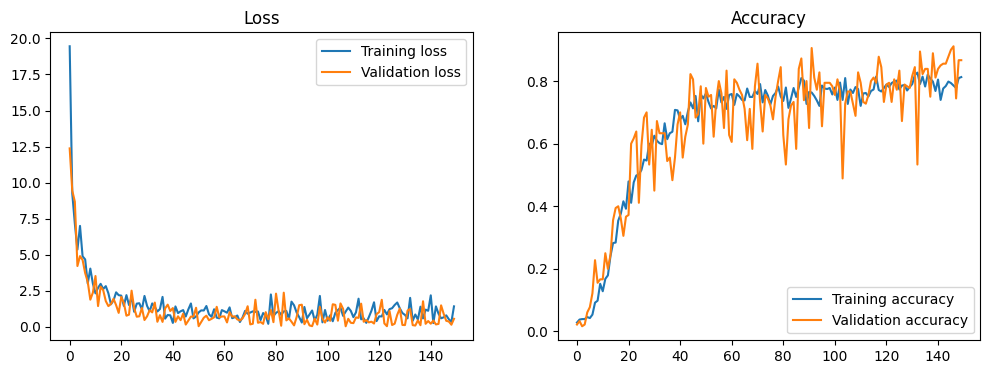

Epoch [151/1100], Loss: 0.9292135238647461, Accuracy: 0.8174603174603174 Correct: 515 Total: 630 LR: 0.0004319545454545459 -> 0.0004315009090909095
Validation Accuracy: 0.8888888888888888 Validation loss: 0.2952932119369507 Correct: 160 Total: 180
Epoch [152/1100], Loss: 0.448435515165329, Accuracy: 0.7507936507936508 Correct: 473 Total: 630 LR: 0.0004315009090909095 -> 0.0004310472727272731
Validation Accuracy: 0.8111111111111111 Validation loss: 1.81210196018219 Correct: 146 Total: 180
Epoch [153/1100], Loss: 1.0546787977218628, Accuracy: 0.8238095238095238 Correct: 519 Total: 630 LR: 0.0004310472727272731 -> 0.00043059363636363676
Validation Accuracy: 0.8722222222222222 Validation loss: 0.12773656845092773 Correct: 157 Total: 180
Epoch [154/1100], Loss: 0.5822647213935852, Accuracy: 0.8365079365079365 Correct: 527 Total: 630 LR: 0.00043059363636363676 -> 0.0004301400000000004
Validation Accuracy: 0.8555555555555555 Validation loss: 1.4732321500778198 Correct: 154 Total: 180
Epoch [1

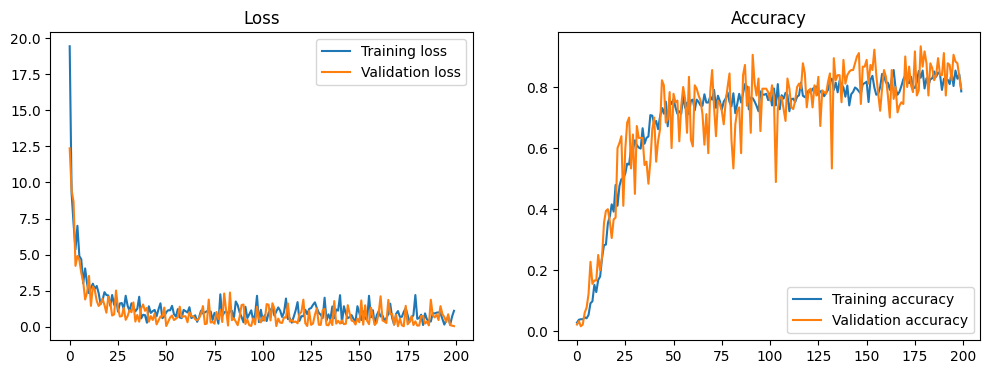

Epoch [201/1100], Loss: 0.651395857334137, Accuracy: 0.8174603174603174 Correct: 515 Total: 630 LR: 0.00040927272727272774 -> 0.0004088190909090914
Validation Accuracy: 0.8166666666666667 Validation loss: 0.2651437819004059 Correct: 147 Total: 180
Epoch [202/1100], Loss: 0.5401208400726318, Accuracy: 0.8174603174603174 Correct: 515 Total: 630 LR: 0.0004088190909090914 -> 0.00040836545454545504
Validation Accuracy: 0.7666666666666667 Validation loss: 2.5862598419189453 Correct: 138 Total: 180
Epoch [203/1100], Loss: 0.8199247717857361, Accuracy: 0.8380952380952381 Correct: 528 Total: 630 LR: 0.00040836545454545504 -> 0.0004079118181818187
Validation Accuracy: 0.8277777777777777 Validation loss: 1.6064834594726562 Correct: 149 Total: 180
Epoch [204/1100], Loss: 0.19404029846191406, Accuracy: 0.8539682539682539 Correct: 538 Total: 630 LR: 0.0004079118181818187 -> 0.00040745818181818234
Validation Accuracy: 0.8 Validation loss: 0.32469627261161804 Correct: 144 Total: 180
Epoch [205/1100], 

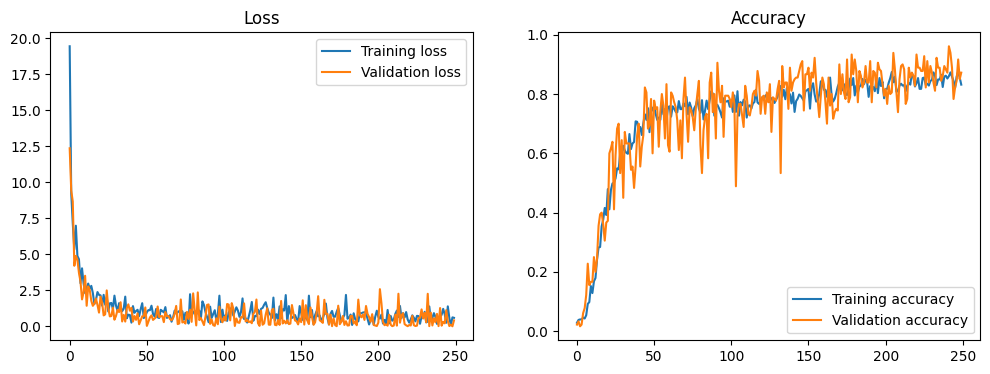

Epoch [251/1100], Loss: 0.4850805997848511, Accuracy: 0.861904761904762 Correct: 543 Total: 630 LR: 0.00038659090909090983 -> 0.0003861372727272735
Validation Accuracy: 0.8333333333333334 Validation loss: 0.3249565660953522 Correct: 150 Total: 180
Epoch [252/1100], Loss: 0.5175924897193909, Accuracy: 0.8269841269841269 Correct: 521 Total: 630 LR: 0.0003861372727272735 -> 0.00038568363636363713
Validation Accuracy: 0.75 Validation loss: 1.0779180526733398 Correct: 135 Total: 180
Epoch [253/1100], Loss: 0.5102571845054626, Accuracy: 0.8666666666666667 Correct: 546 Total: 630 LR: 0.00038568363636363713 -> 0.0003852300000000008
Validation Accuracy: 0.8611111111111112 Validation loss: 0.4936443269252777 Correct: 155 Total: 180
Epoch [254/1100], Loss: 0.432586669921875, Accuracy: 0.8634920634920635 Correct: 544 Total: 630 LR: 0.0003852300000000008 -> 0.00038477636363636443
Validation Accuracy: 0.8777777777777778 Validation loss: 0.013515747152268887 Correct: 158 Total: 180
Epoch [255/1100], 

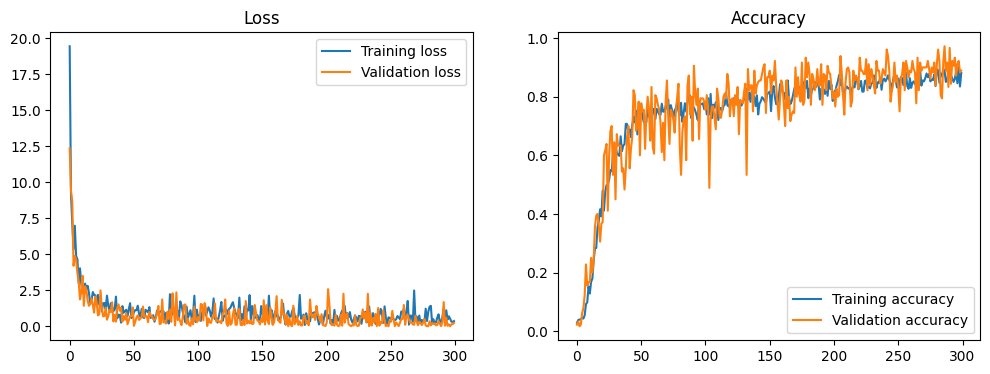

Epoch [301/1100], Loss: 0.2790186405181885, Accuracy: 0.8682539682539683 Correct: 547 Total: 630 LR: 0.0003639090909090916 -> 0.00036345545454545525
Validation Accuracy: 0.9111111111111111 Validation loss: 0.04581189155578613 Correct: 164 Total: 180
Epoch [302/1100], Loss: 0.6479288339614868, Accuracy: 0.8698412698412699 Correct: 548 Total: 630 LR: 0.00036345545454545525 -> 0.0003630018181818189
Validation Accuracy: 0.8833333333333333 Validation loss: 0.36726611852645874 Correct: 159 Total: 180
Epoch [303/1100], Loss: 1.39133882522583, Accuracy: 0.8777777777777778 Correct: 553 Total: 630 LR: 0.0003630018181818189 -> 0.00036254818181818255
Validation Accuracy: 0.9111111111111111 Validation loss: 0.022197064012289047 Correct: 164 Total: 180
Epoch [304/1100], Loss: 0.1999654322862625, Accuracy: 0.8809523809523809 Correct: 555 Total: 630 LR: 0.00036254818181818255 -> 0.0003620945454545462
Validation Accuracy: 0.9166666666666666 Validation loss: 0.1489010602235794 Correct: 165 Total: 180
Ep

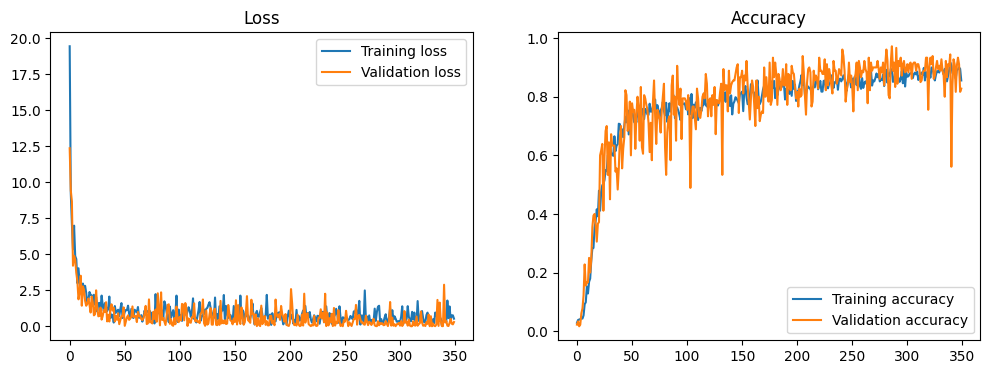

Epoch [351/1100], Loss: 0.5190927982330322, Accuracy: 0.8714285714285714 Correct: 549 Total: 630 LR: 0.0003412272727272734 -> 0.000340773636363637
Validation Accuracy: 0.8722222222222222 Validation loss: 0.00900961458683014 Correct: 157 Total: 180
Epoch [352/1100], Loss: 1.0217722654342651, Accuracy: 0.8746031746031746 Correct: 551 Total: 630 LR: 0.000340773636363637 -> 0.00034032000000000067
Validation Accuracy: 0.9166666666666666 Validation loss: 0.9145212173461914 Correct: 165 Total: 180
Epoch [353/1100], Loss: 0.3835254907608032, Accuracy: 0.8761904761904762 Correct: 552 Total: 630 LR: 0.00034032000000000067 -> 0.0003398663636363643
Validation Accuracy: 0.9166666666666666 Validation loss: 0.028680430725216866 Correct: 165 Total: 180
Epoch [354/1100], Loss: 0.4049900770187378, Accuracy: 0.8714285714285714 Correct: 549 Total: 630 LR: 0.0003398663636363643 -> 0.00033941272727272797
Validation Accuracy: 0.8555555555555555 Validation loss: 0.02987300604581833 Correct: 154 Total: 180
Epo

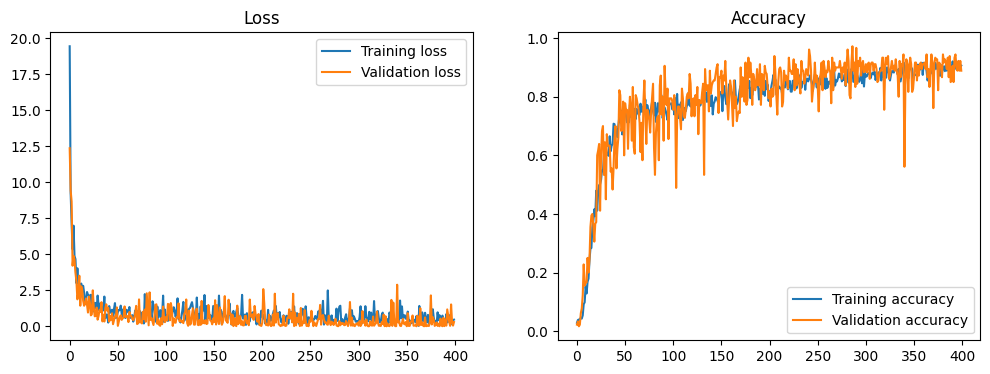

Epoch [401/1100], Loss: 0.5019451379776001, Accuracy: 0.8984126984126984 Correct: 566 Total: 630 LR: 0.00031854545454545547 -> 0.0003180918181818191
Validation Accuracy: 0.9 Validation loss: 0.9113055467605591 Correct: 162 Total: 180
Epoch [402/1100], Loss: 0.577748715877533, Accuracy: 0.8841269841269841 Correct: 557 Total: 630 LR: 0.0003180918181818191 -> 0.00031763818181818277
Validation Accuracy: 0.9444444444444444 Validation loss: 0.7746594548225403 Correct: 170 Total: 180
Epoch [403/1100], Loss: 0.3260762095451355, Accuracy: 0.9238095238095239 Correct: 582 Total: 630 LR: 0.00031763818181818277 -> 0.0003171845454545464
Validation Accuracy: 0.8777777777777778 Validation loss: 0.05085642263293266 Correct: 158 Total: 180
Epoch [404/1100], Loss: 0.07209187746047974, Accuracy: 0.9047619047619048 Correct: 570 Total: 630 LR: 0.0003171845454545464 -> 0.00031673090909091007
Validation Accuracy: 0.95 Validation loss: 0.009930781088769436 Correct: 171 Total: 180
Epoch [405/1100], Loss: 0.2404

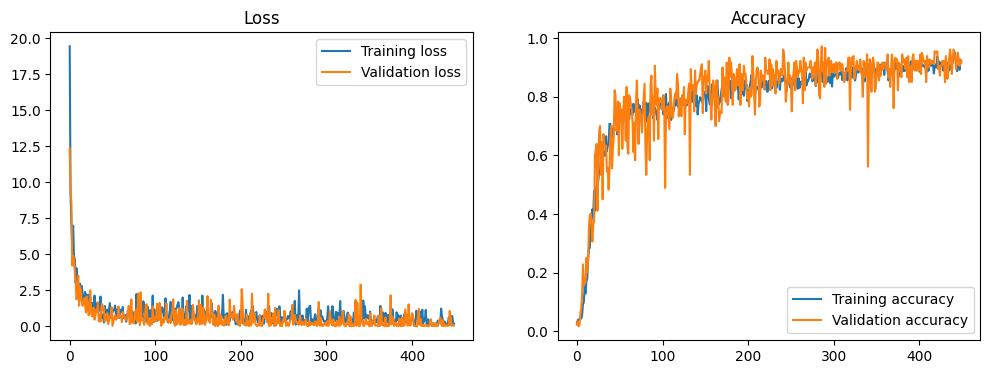

Epoch [451/1100], Loss: 0.30768588185310364, Accuracy: 0.9047619047619048 Correct: 570 Total: 630 LR: 0.00029586363636363735 -> 0.000295410000000001
Validation Accuracy: 0.9444444444444444 Validation loss: 0.14649812877178192 Correct: 170 Total: 180
Epoch [452/1100], Loss: 0.2535026967525482, Accuracy: 0.9015873015873016 Correct: 568 Total: 630 LR: 0.000295410000000001 -> 0.00029495636363636464
Validation Accuracy: 0.8444444444444444 Validation loss: 0.03077172115445137 Correct: 152 Total: 180
Epoch [453/1100], Loss: 0.34019801020622253, Accuracy: 0.9412698412698413 Correct: 593 Total: 630 LR: 0.00029495636363636464 -> 0.0002945027272727283
Validation Accuracy: 0.9222222222222223 Validation loss: 0.05418996885418892 Correct: 166 Total: 180
Epoch [454/1100], Loss: 0.760341227054596, Accuracy: 0.9253968253968254 Correct: 583 Total: 630 LR: 0.0002945027272727283 -> 0.00029404909090909194
Validation Accuracy: 0.9222222222222223 Validation loss: 0.6276048421859741 Correct: 166 Total: 180
Ep

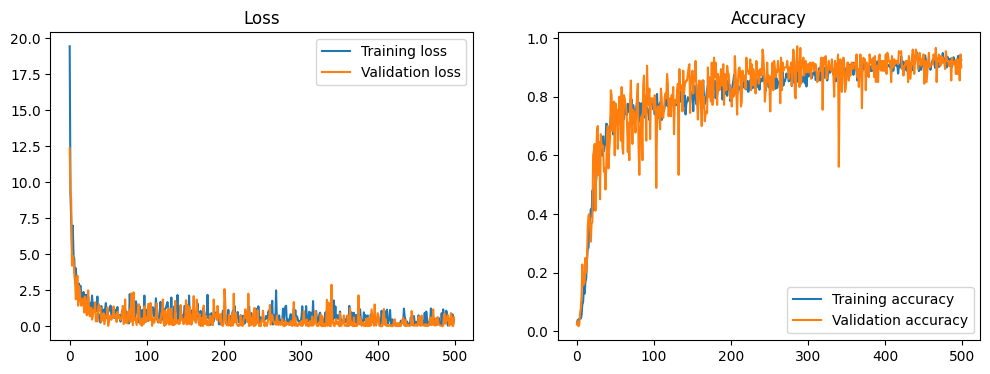

Epoch [501/1100], Loss: 0.22696362435817719, Accuracy: 0.9158730158730158 Correct: 577 Total: 630 LR: 0.00027318181818181977 -> 0.0002727281818181834
Validation Accuracy: 0.8944444444444445 Validation loss: 0.7013874053955078 Correct: 161 Total: 180
Epoch [502/1100], Loss: 0.44223812222480774, Accuracy: 0.9079365079365079 Correct: 572 Total: 630 LR: 0.0002727281818181834 -> 0.00027227454545454706
Validation Accuracy: 0.8777777777777778 Validation loss: 0.40145641565322876 Correct: 158 Total: 180
Epoch [503/1100], Loss: 0.3683103024959564, Accuracy: 0.8873015873015873 Correct: 559 Total: 630 LR: 0.00027227454545454706 -> 0.0002718209090909107
Validation Accuracy: 0.9222222222222223 Validation loss: 0.002288073766976595 Correct: 166 Total: 180
Epoch [504/1100], Loss: 1.1660181283950806, Accuracy: 0.9285714285714286 Correct: 585 Total: 630 LR: 0.0002718209090909107 -> 0.00027136727272727436
Validation Accuracy: 0.9388888888888889 Validation loss: 0.10032729059457779 Correct: 169 Total: 18

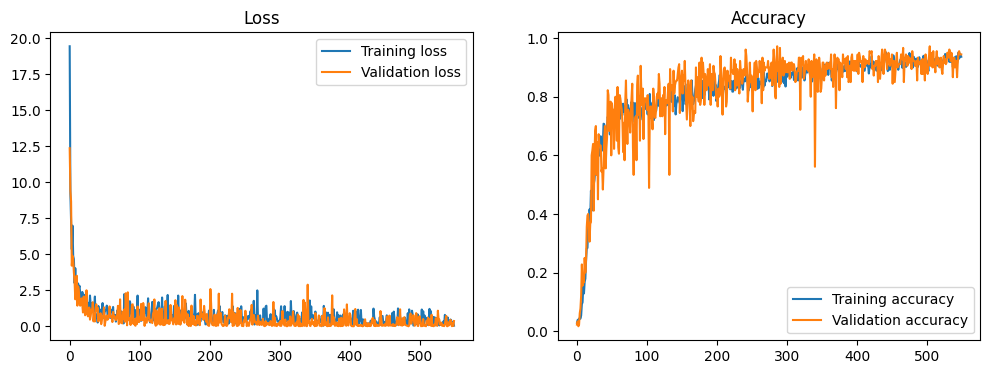

Epoch [551/1100], Loss: 1.1655648946762085, Accuracy: 0.9142857142857143 Correct: 576 Total: 630 LR: 0.000250500000000002 -> 0.00025004636363636567
Validation Accuracy: 0.8888888888888888 Validation loss: 0.029067547991871834 Correct: 160 Total: 180
Epoch [552/1100], Loss: 0.9454534649848938, Accuracy: 0.919047619047619 Correct: 579 Total: 630 LR: 0.00025004636363636567 -> 0.0002495927272727293
Validation Accuracy: 0.9444444444444444 Validation loss: 0.8697969317436218 Correct: 170 Total: 180
Epoch [553/1100], Loss: 0.2999340295791626, Accuracy: 0.9396825396825397 Correct: 592 Total: 630 LR: 0.0002495927272727293 -> 0.00024913909090909297
Validation Accuracy: 0.95 Validation loss: 0.03354567661881447 Correct: 171 Total: 180
Epoch [554/1100], Loss: 0.09554482251405716, Accuracy: 0.9301587301587302 Correct: 586 Total: 630 LR: 0.00024913909090909297 -> 0.00024868545454545657
Validation Accuracy: 0.8833333333333333 Validation loss: 0.09551949799060822 Correct: 159 Total: 180
Epoch [555/110

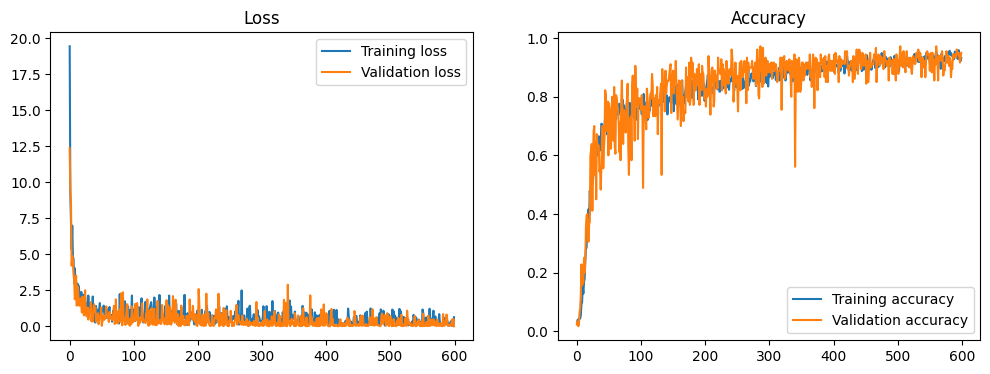

Epoch [601/1100], Loss: 0.41714200377464294, Accuracy: 0.9222222222222223 Correct: 581 Total: 630 LR: 0.00022781818181818385 -> 0.00022736454545454747
Validation Accuracy: 0.9166666666666666 Validation loss: 0.03666310012340546 Correct: 165 Total: 180
Epoch [602/1100], Loss: 0.41753795742988586, Accuracy: 0.9253968253968254 Correct: 583 Total: 630 LR: 0.00022736454545454747 -> 0.0002269109090909111
Validation Accuracy: 0.9444444444444444 Validation loss: 0.024737920612096786 Correct: 170 Total: 180
Epoch [603/1100], Loss: 0.13243864476680756, Accuracy: 0.9444444444444444 Correct: 595 Total: 630 LR: 0.0002269109090909111 -> 0.00022645727272727471
Validation Accuracy: 0.9333333333333333 Validation loss: 0.2923648953437805 Correct: 168 Total: 180
Epoch [604/1100], Loss: 0.6023274660110474, Accuracy: 0.9428571428571428 Correct: 594 Total: 630 LR: 0.00022645727272727471 -> 0.00022600363636363834
Validation Accuracy: 0.9388888888888889 Validation loss: 0.8961280584335327 Correct: 169 Total: 

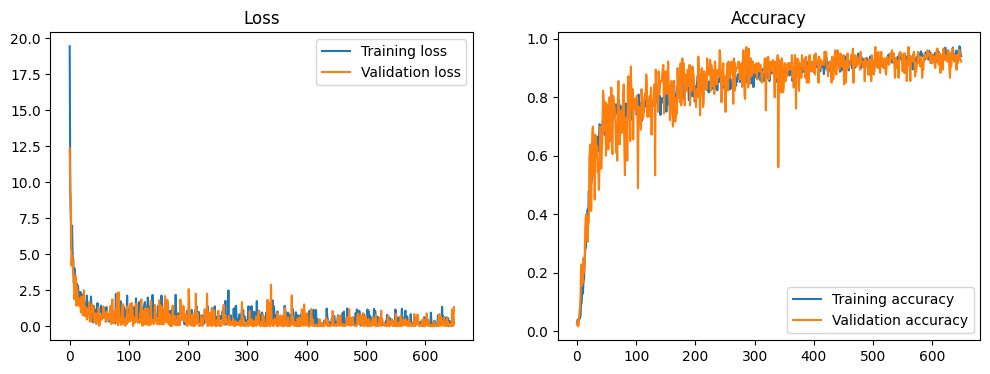

Epoch [651/1100], Loss: 0.0940794125199318, Accuracy: 0.9650793650793651 Correct: 608 Total: 630 LR: 0.0002051363636363653 -> 0.0002046827272727289
Validation Accuracy: 0.9555555555555556 Validation loss: 0.0036163548938930035 Correct: 172 Total: 180
Epoch [652/1100], Loss: 0.6854581236839294, Accuracy: 0.9587301587301588 Correct: 604 Total: 630 LR: 0.0002046827272727289 -> 0.00020422909090909256
Validation Accuracy: 0.9111111111111111 Validation loss: 0.7109673023223877 Correct: 164 Total: 180
Epoch [653/1100], Loss: 0.14299441874027252, Accuracy: 0.9587301587301588 Correct: 604 Total: 630 LR: 0.00020422909090909256 -> 0.0002037754545454562
Validation Accuracy: 0.9111111111111111 Validation loss: 0.7573531866073608 Correct: 164 Total: 180
Epoch [654/1100], Loss: 0.16109104454517365, Accuracy: 0.946031746031746 Correct: 596 Total: 630 LR: 0.0002037754545454562 -> 0.00020332181818181986
Validation Accuracy: 0.9 Validation loss: 0.01690119132399559 Correct: 162 Total: 180
Epoch [655/1100

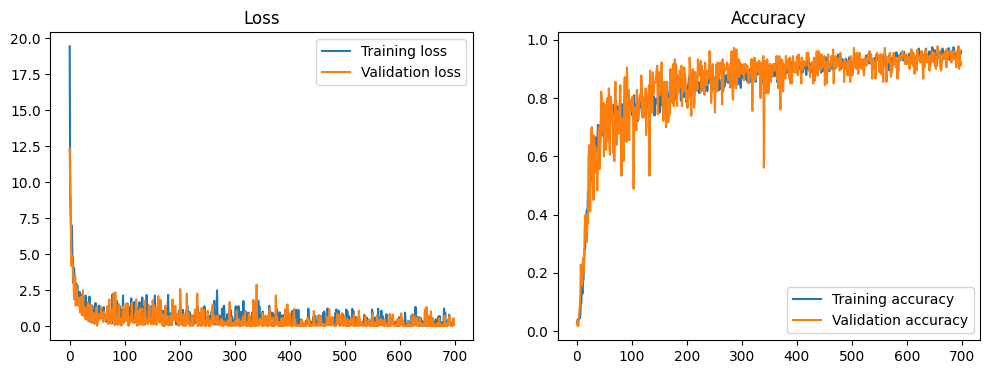

Epoch [701/1100], Loss: 0.4891696870326996, Accuracy: 0.9571428571428572 Correct: 603 Total: 630 LR: 0.000182454545454547 -> 0.00018200090909091066
Validation Accuracy: 0.9055555555555556 Validation loss: 0.46784427762031555 Correct: 163 Total: 180
Epoch [702/1100], Loss: 0.11500707268714905, Accuracy: 0.9301587301587302 Correct: 586 Total: 630 LR: 0.00018200090909091066 -> 0.0001815472727272743
Validation Accuracy: 0.9166666666666666 Validation loss: 0.03818054869771004 Correct: 165 Total: 180
Epoch [703/1100], Loss: 0.16506068408489227, Accuracy: 0.9492063492063492 Correct: 598 Total: 630 LR: 0.0001815472727272743 -> 0.00018109363636363793
Validation Accuracy: 0.9388888888888889 Validation loss: 1.6013410091400146 Correct: 169 Total: 180
Epoch [704/1100], Loss: 0.11970043182373047, Accuracy: 0.9555555555555556 Correct: 602 Total: 630 LR: 0.00018109363636363793 -> 0.00018064000000000155
Validation Accuracy: 0.9444444444444444 Validation loss: 0.014895476400852203 Correct: 170 Total: 1

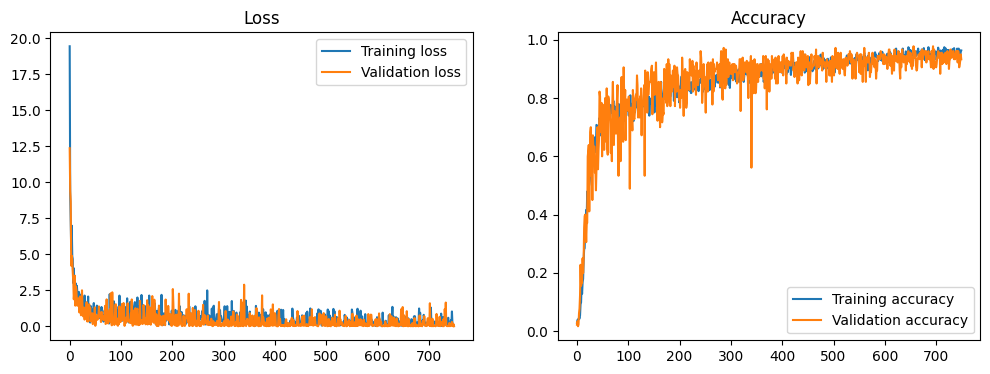

Epoch [751/1100], Loss: 0.2273920774459839, Accuracy: 0.9650793650793651 Correct: 608 Total: 630 LR: 0.0001597727272727286 -> 0.00015931909090909224
Validation Accuracy: 0.9444444444444444 Validation loss: 0.02607886865735054 Correct: 170 Total: 180
Epoch [752/1100], Loss: 0.3042501211166382, Accuracy: 0.9634920634920635 Correct: 607 Total: 630 LR: 0.00015931909090909224 -> 0.00015886545454545589
Validation Accuracy: 0.9611111111111111 Validation loss: 0.06422604620456696 Correct: 173 Total: 180
Epoch [753/1100], Loss: 0.11850646138191223, Accuracy: 0.9555555555555556 Correct: 602 Total: 630 LR: 0.00015886545454545589 -> 0.0001584118181818195
Validation Accuracy: 0.9555555555555556 Validation loss: 0.32993659377098083 Correct: 172 Total: 180
Epoch [754/1100], Loss: 0.2872118353843689, Accuracy: 0.9650793650793651 Correct: 608 Total: 630 LR: 0.0001584118181818195 -> 0.00015795818181818313
Validation Accuracy: 0.9666666666666667 Validation loss: 0.025098931044340134 Correct: 174 Total: 1

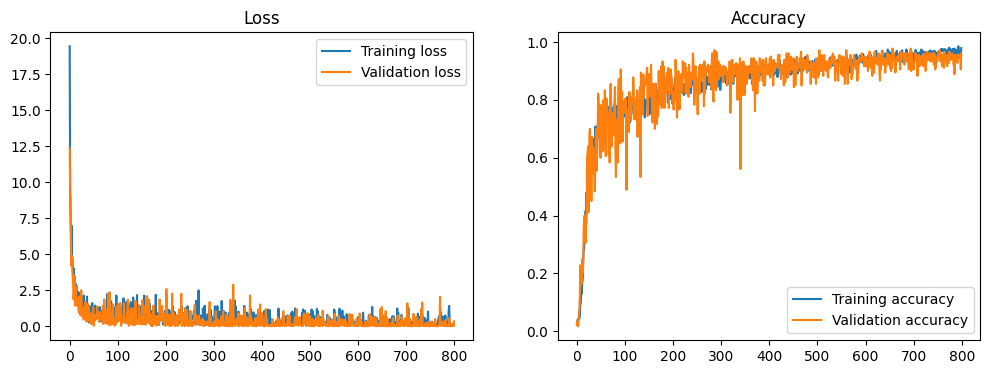

Epoch [801/1100], Loss: 0.10787860304117203, Accuracy: 0.9746031746031746 Correct: 614 Total: 630 LR: 0.00013709090909091036 -> 0.000136637272727274
Validation Accuracy: 0.9222222222222223 Validation loss: 0.013084344565868378 Correct: 166 Total: 180
Epoch [802/1100], Loss: 0.2835118770599365, Accuracy: 0.9714285714285714 Correct: 612 Total: 630 LR: 0.000136637272727274 -> 0.00013618363636363765
Validation Accuracy: 0.9611111111111111 Validation loss: 0.03410576283931732 Correct: 173 Total: 180
Epoch [803/1100], Loss: 0.35218527913093567, Accuracy: 0.9603174603174603 Correct: 605 Total: 630 LR: 0.00013618363636363765 -> 0.00013573000000000128
Validation Accuracy: 0.9666666666666667 Validation loss: 0.011712263338267803 Correct: 174 Total: 180
Epoch [804/1100], Loss: 0.2637096643447876, Accuracy: 0.9650793650793651 Correct: 608 Total: 630 LR: 0.00013573000000000128 -> 0.0001352763636363649
Validation Accuracy: 0.9611111111111111 Validation loss: 0.011380479671061039 Correct: 173 Total: 

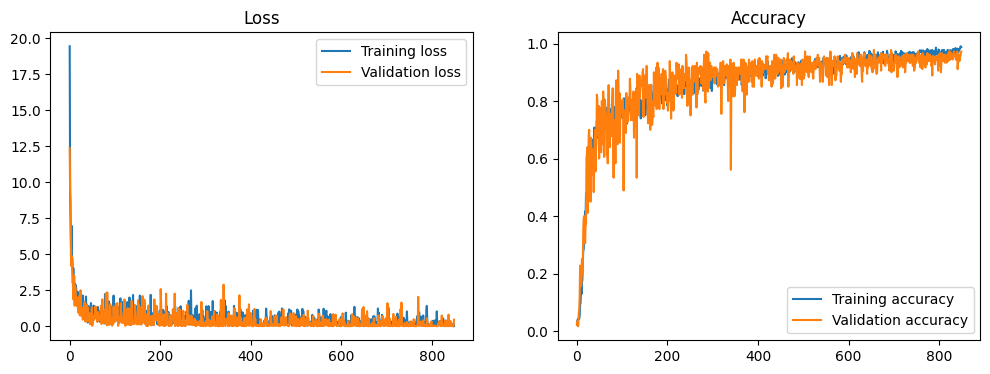

Epoch [851/1100], Loss: 0.40747252106666565, Accuracy: 0.9777777777777777 Correct: 616 Total: 630 LR: 0.00011440909090909198 -> 0.00011395545454545561
Validation Accuracy: 0.9388888888888889 Validation loss: 1.7728334665298462 Correct: 169 Total: 180
Epoch [852/1100], Loss: 0.3528090715408325, Accuracy: 0.9634920634920635 Correct: 607 Total: 630 LR: 0.00011395545454545561 -> 0.00011350181818181925
Validation Accuracy: 0.9555555555555556 Validation loss: 0.009754692204296589 Correct: 172 Total: 180
Epoch [853/1100], Loss: 0.24278581142425537, Accuracy: 0.9587301587301588 Correct: 604 Total: 630 LR: 0.00011350181818181925 -> 0.00011304818181818287
Validation Accuracy: 0.9555555555555556 Validation loss: 0.2479872703552246 Correct: 172 Total: 180
Epoch [854/1100], Loss: 0.0871424674987793, Accuracy: 0.9698412698412698 Correct: 611 Total: 630 LR: 0.00011304818181818287 -> 0.0001125945454545465
Validation Accuracy: 0.9333333333333333 Validation loss: 0.26804107427597046 Correct: 168 Total: 

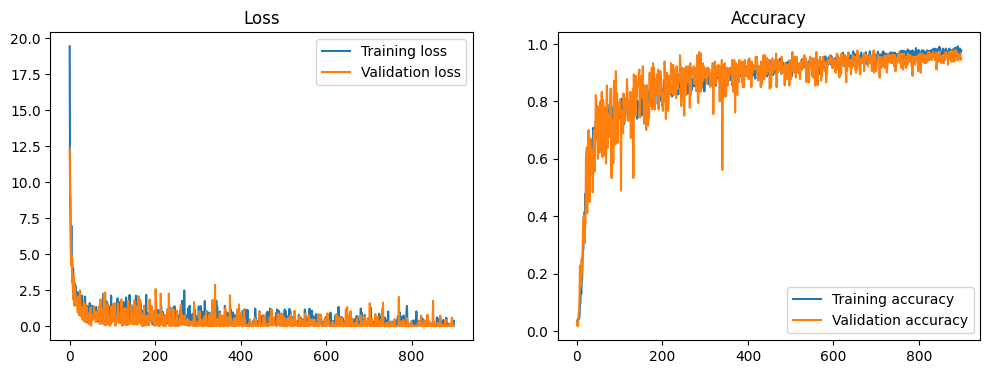

Epoch [901/1100], Loss: 0.038885343819856644, Accuracy: 0.9841269841269841 Correct: 620 Total: 630 LR: 9.172727272727361e-05 -> 9.127363636363725e-05
Validation Accuracy: 0.95 Validation loss: 0.010107939131557941 Correct: 171 Total: 180
Epoch [902/1100], Loss: 0.0911300852894783, Accuracy: 0.9873015873015873 Correct: 622 Total: 630 LR: 9.127363636363725e-05 -> 9.082000000000088e-05
Validation Accuracy: 0.9388888888888889 Validation loss: 0.03887023404240608 Correct: 169 Total: 180
Epoch [903/1100], Loss: 0.07486140727996826, Accuracy: 0.9714285714285714 Correct: 612 Total: 630 LR: 9.082000000000088e-05 -> 9.036636363636452e-05
Validation Accuracy: 0.9444444444444444 Validation loss: 0.0059312861412763596 Correct: 170 Total: 180
Epoch [904/1100], Loss: 0.059182893484830856, Accuracy: 0.973015873015873 Correct: 613 Total: 630 LR: 9.036636363636452e-05 -> 8.991272727272815e-05
Validation Accuracy: 0.9666666666666667 Validation loss: 0.10959133505821228 Correct: 174 Total: 180
Epoch [905/

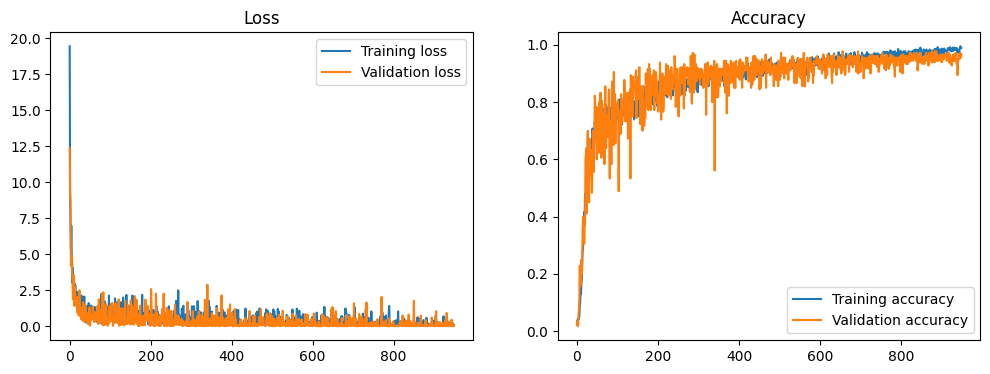

Epoch [951/1100], Loss: 0.33411750197410583, Accuracy: 0.9809523809523809 Correct: 618 Total: 630 LR: 6.904545454545533e-05 -> 6.859181818181895e-05
Validation Accuracy: 0.9555555555555556 Validation loss: 0.008656822144985199 Correct: 172 Total: 180
Epoch [952/1100], Loss: 0.10974109172821045, Accuracy: 0.9682539682539683 Correct: 610 Total: 630 LR: 6.859181818181895e-05 -> 6.813818181818258e-05
Validation Accuracy: 0.9611111111111111 Validation loss: 0.1464177966117859 Correct: 173 Total: 180
Epoch [953/1100], Loss: 0.086466945707798, Accuracy: 0.9904761904761905 Correct: 624 Total: 630 LR: 6.813818181818258e-05 -> 6.768454545454622e-05
Validation Accuracy: 0.9666666666666667 Validation loss: 0.08099200576543808 Correct: 174 Total: 180
Epoch [954/1100], Loss: 0.04530125856399536, Accuracy: 0.9793650793650793 Correct: 617 Total: 630 LR: 6.768454545454622e-05 -> 6.723090909090986e-05
Validation Accuracy: 0.9555555555555556 Validation loss: 0.011787471361458302 Correct: 172 Total: 180
E

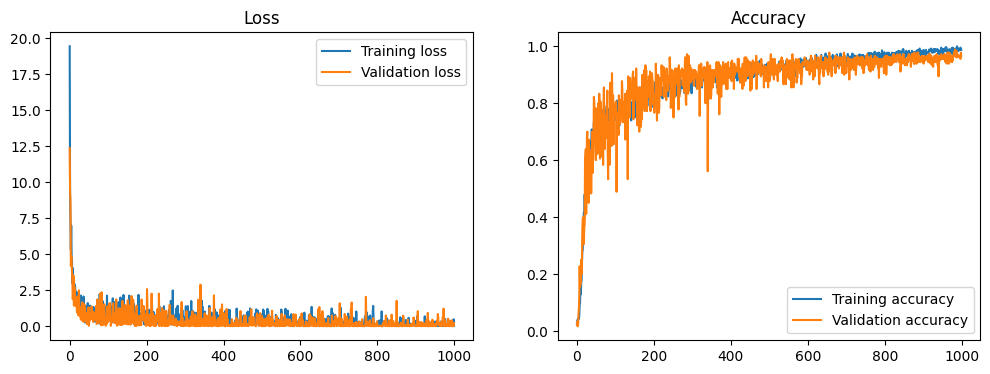

Epoch [1001/1100], Loss: 0.02975478582084179, Accuracy: 0.9936507936507937 Correct: 626 Total: 630 LR: 4.6363636363636885e-05 -> 4.591000000000052e-05
Validation Accuracy: 0.9777777777777777 Validation loss: 0.2870626449584961 Correct: 176 Total: 180
Epoch [1002/1100], Loss: 0.042022738605737686, Accuracy: 0.9841269841269841 Correct: 620 Total: 630 LR: 4.591000000000052e-05 -> 4.545636363636415e-05
Validation Accuracy: 0.9666666666666667 Validation loss: 0.06634521484375 Correct: 174 Total: 180
Epoch [1003/1100], Loss: 0.011483565904200077, Accuracy: 0.9952380952380953 Correct: 627 Total: 630 LR: 4.545636363636415e-05 -> 4.500272727272778e-05
Validation Accuracy: 0.9722222222222222 Validation loss: 0.16642865538597107 Correct: 175 Total: 180
Epoch [1004/1100], Loss: 0.04743335768580437, Accuracy: 0.9793650793650793 Correct: 617 Total: 630 LR: 4.500272727272778e-05 -> 4.4549090909091415e-05
Validation Accuracy: 0.9555555555555556 Validation loss: 0.024070462211966515 Correct: 172 Total:

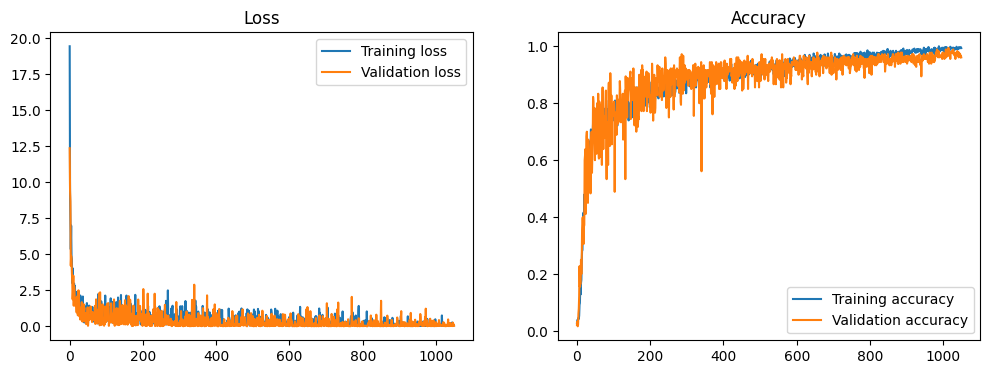

Epoch [1051/1100], Loss: 0.11449532955884933, Accuracy: 0.9936507936507937 Correct: 626 Total: 630 LR: 2.3681818181818428e-05 -> 2.322818181818206e-05
Validation Accuracy: 0.9777777777777777 Validation loss: 0.012064049951732159 Correct: 176 Total: 180
Epoch [1052/1100], Loss: 0.14427964389324188, Accuracy: 0.9984126984126984 Correct: 629 Total: 630 LR: 2.322818181818206e-05 -> 2.2774545454545693e-05
Validation Accuracy: 0.9722222222222222 Validation loss: 0.008551042526960373 Correct: 175 Total: 180
Epoch [1053/1100], Loss: 0.03520846366882324, Accuracy: 0.9952380952380953 Correct: 627 Total: 630 LR: 2.2774545454545693e-05 -> 2.2320909090909325e-05
Validation Accuracy: 0.9666666666666667 Validation loss: 0.42123663425445557 Correct: 174 Total: 180
Epoch [1054/1100], Loss: 0.0355866514146328, Accuracy: 0.9920634920634921 Correct: 625 Total: 630 LR: 2.2320909090909325e-05 -> 2.1867272727272958e-05
Validation Accuracy: 0.9611111111111111 Validation loss: 0.11445987969636917 Correct: 173 

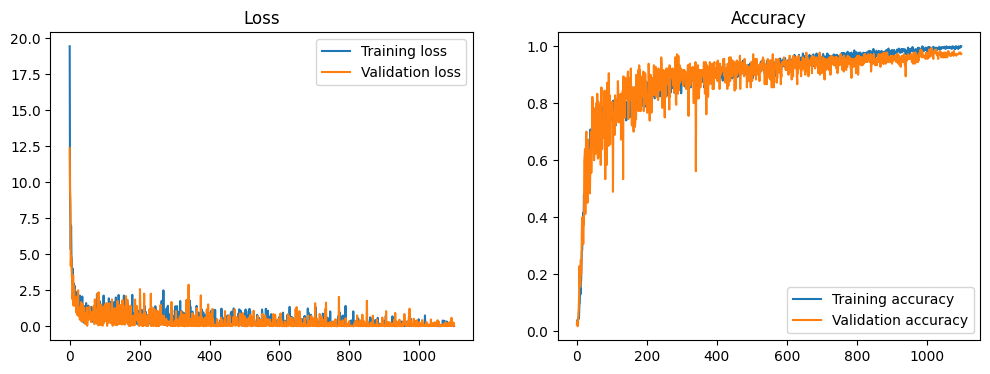

In [28]:
best_model_path = "CoAtNet-1-Best-Phone.pkl"
model_path = "CoAtNet-1-Phone.pkl"

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = torch.squeeze(labels).to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = cost(outputs, torch.squeeze(labels))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()
        
        previous_lr = scheduler.get_last_lr()[0]
        scheduler.step()
        next_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {correct/total}", "Correct:", correct, "Total:", total, f"LR: {previous_lr} -> {next_lr}")
        train_losses.append(loss.item())
        train_accuracies.append(correct/total)

        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = torch.squeeze(labels).to(device)
                outputs = model(inputs)
                
                loss = cost(outputs, torch.squeeze(labels))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f"Validation Accuracy: {correct/total}", f"Validation loss: {loss}", "Correct:", correct, "Total:", total)
            val_losses.append(loss.item())
            val_accuracies.append(correct/total)
        
        if epoch != 0 and (epoch % 50 == 49):
            plot_results(train_losses, train_accuracies, val_losses, val_accuracies)
        if epoch > 2 and val_accuracies[-1] > max(val_accuracies[:-1]):
            save_model(model, best_model_path)

In [29]:
save_model(model, model_path)

### Results

In [30]:
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

MyCoAtNet(
  (0): Sequential(
    (0): Stem(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    )
  )
  (1): Sequential(
    (0): DownsamplingMBConv(
      (mb_conv): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): GELU(approximate='none')
        (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
        (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): GELU(approximate='none')
        (7): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
    

In [31]:
print("Best validation acc: ", max(val_accuracies))
print("Last validation acc: ", val_accuracies[-1])

Best validation acc:  0.9944444444444445
Last validation acc:  0.9722222222222222


In [32]:
# Generate the alphabet (0-9 and A-Z)
digits = [str(digit) for digit in range(10)]
alphabet = [chr(ascii_code) for ascii_code in range(ord('A'), ord('Z') + 1)]

# Combine digits and alphabet
all_characters = digits + alphabet

# Create the label dictionary
label_dict = {i: all_characters[i] for i in range(len(all_characters))}

# Print the label dictionary
print(label_dict)


{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}


In [33]:
# Adapted from My_CoAtNet
predictions_path = 'predictions-phone.csv'

def predict(data_loader):

    original_labels = []
    predicted_labels = []

    correct = 0
    total = 0
    
    model.eval()
    
    for inputs, labels in data_loader:

        inputs = inputs.to(device)
        labels = torch.squeeze(labels).to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
      
        original_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    prediction_df = pd.DataFrame({"predicted_labels": [label_dict[pred] for pred in predicted_labels], "true_labels": [label_dict[label] for label in original_labels]})
    prediction_df.to_csv(predictions_path)

    print(f"Test Accuracy: {correct/total}")
    pd.set_option('display.max_rows', None)
    pd.set_option("display.max_columns", None)
    display(prediction_df.T)
    
    print (metrics.accuracy_score(original_labels, predicted_labels))
    print (metrics.classification_report(original_labels, predicted_labels))
    
    return confusion_matrix(original_labels, predicted_labels)

### Test accuracy

In [34]:
cm = predict(test_dataloader)

Test Accuracy: 0.9666666666666667


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
predicted_labels,T,Q,2,8,L,B,X,3,4,U,A,O,B,Y,N,9,7,Z,P,9,J,K,N,G,G,P,B,P,H,A,6,2,M,6,0,A,Y,Z,O,7,W,P,1,T,W,5,E,0,1,B,G,6,I,M,8,S,W,V,X,Z,L,I,1,R,8,D,B,B,W,M,C,7,H,I,2,M,3,B,4,T,A,O,V,K,F,Q,G,7,J,9
true_labels,T,Q,2,8,L,B,C,3,4,U,A,O,B,Y,N,9,7,Z,P,9,J,K,N,G,G,P,B,P,H,A,6,2,M,6,0,A,Y,Z,O,7,W,P,1,T,W,5,E,0,1,B,G,6,I,M,8,W,W,V,X,Z,L,I,1,R,8,D,B,B,W,M,C,7,H,I,2,M,3,B,4,T,A,Z,V,K,F,Q,G,7,J,9


0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         7
          12       1.00      0.50      0.67         2
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         4
        

c:\Users\user\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Confusion matrix

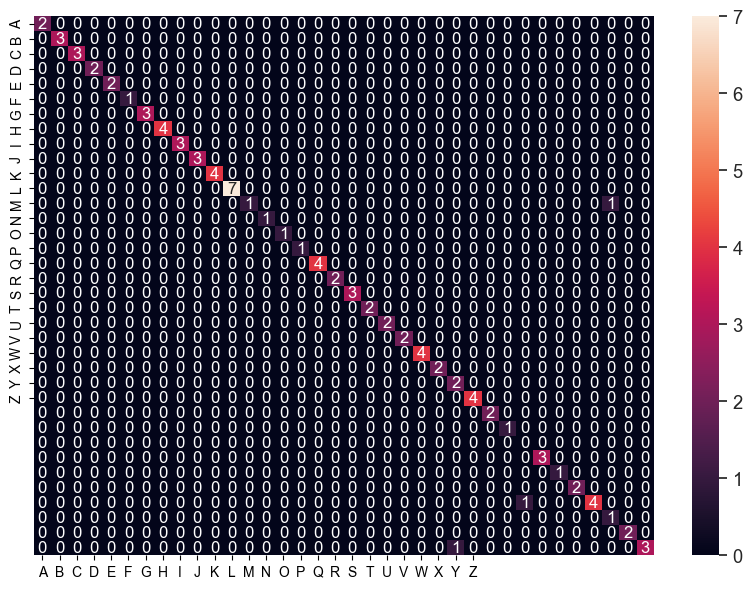

In [35]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=alphabet, 
                yticklabels=alphabet,
                annot_kws={"size": 12}
                )
fig.savefig("confusion_matrix_CoAtNet-1")